In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read data

In [35]:
data_path = './preprocessed data/'

In [36]:
df_test = {}
impute =  os.listdir(data_path)
for method in impute:
    goto = data_path + str(method)
    if method == 'drop_all_nan.csv':
        df_raw = pd.read_csv(goto, index_col=0).reset_index().round(3).iloc[:,1:]
        df_raw = df_raw[['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','0','1','2','3','4','5','6']]

    elif method == 'ctgan.csv':
        df_test[method] = pd.read_csv(goto, index_col=0)
        df_test[method] = df_test[method][['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','0','1','2','3','4','5','6']]
    
    else:
        df_test[method] = pd.read_csv(goto, index_col=0).reset_index().round(3).iloc[:,3:]
        df_test[method] = df_test[method][['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','0','1','2','3','4','5','6']]


In [37]:
df_test['ctgan.csv']

,7,8,9,10,11,12,13,14,15,16,...,21,22,23,0,1,2,3,4,5,6
0,127.187570,142.231646,181.850852,127.708664,95.296961,147.981640,123.571247,106.805808,175.213100,185.998345,...,149.688022,106.181496,85.307066,137.439312,140.836249,143.705557,101.932233,117.274861,138.892329,137.113829
1,179.609424,120.587920,134.161201,53.075324,89.513617,127.530351,185.306080,106.960145,92.139862,117.220223,...,118.062064,98.327276,120.281660,92.310402,142.918527,118.221317,104.071457,121.607910,184.892618,140.362478
2,172.304759,138.826701,154.629680,112.185711,82.023763,153.622201,101.352063,154.133743,148.373677,223.971373,...,97.639985,114.262391,182.908827,141.389022,162.331525,131.302416,165.538640,81.420596,79.707949,143.760801
3,138.967189,111.287055,183.453575,141.807558,136.205069,144.106993,115.219654,180.867794,215.712181,103.426294,...,76.258133,108.373350,158.046445,105.001813,96.906941,108.673398,132.455333,157.957594,87.829591,103.869532
4,222.424085,146.099550,83.714691,159.127069,96.835326,152.903012,148.454345,132.524496,147.323703,100.769999,...,98.782669,114.843375,107.302515,142.155781,143.892297,94.864056,80.028754,161.249276,120.206047,136.002937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,247.232927,157.143891,113.853635,58.771267,96.630911,153.118572,95.274243,160.650627,106.854867,105.877589,...,99.865690,171.806566,162.197522,105.798064,142.993311,86.316223,113.831064,106.692154,69.373501,140.754212
138,216.603566,97.620616,163.963502,78.277457,109.440394,162.760415,95.067749,103.411334,109.284316,104.164966,...,110.103162,124.597147,144.435878,121.129914,155.299833,106.095344,102.815912,98.956225,110.339744,93.239600
139,206.161552,164.512060,136.039284,109.659146,89.937029,125.987352,120.775663,149.183215,157.101886,120.557723,...,138.942760,116.791385,165.657969,104.091379,106.049365,112.971092,111.432755,136.081309,112.570681,111.885247
140,158.700100,136.061156,167.444758,99.455553,66.773241,185.592570,92.533921,144.149261,210.683365,106.478377,...,100.158729,188.723664,136.957131,130.821623,127.012710,102.706921,118.118961,152.021709,93.887210,118.458693


# Split x, y

In [38]:
X = df_raw.iloc[:,:15] # 142 rows × 15 columns
y = df_raw.iloc[:,15:] # 142 rows × 9 columns

In [39]:
print(f'feature shape:{X.shape}')
print(f'target shape:{y.shape}')

feature shape:(142, 15)
target shape:(142, 9)


# LSTM model

In [45]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import KFold

In [46]:
def create_gru_model(timesteps, features, verbose):
    model = Sequential([
        GRU(units=50, activation='relu', input_shape=(timesteps, features), return_sequences=False),
        Dense(24-timesteps)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    if verbose:
        print(model.summary())
    return model

In [47]:
kf = KFold(n_splits=5)
loss_list = []
non_nighttime_size = 15
min_loss = 1000000

# Perform cross-validation
for train_index, test_index in kf.split(X,y):

    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    # Reshape input X into a 3D tensor with shape (num_samples, timesteps, features_per_timestep)
    timesteps = len(X_train.columns) # 15
    X_train_3d = X_train.values.reshape((len(X_train), timesteps, 1))
    X_test_3d = X_test.values.reshape((len(X_test), timesteps, 1))

    # Create and train the RNN model
    model = create_gru_model(timesteps, 1,verbose=False)
    model.fit(X_train_3d, y_train, epochs=10, batch_size=16, validation_data=(X_test_3d, y_test))

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test_3d, y_test)
    loss_list.append(test_loss)
    print(f'Test Loss: {test_loss}')
    if test_loss < min_loss:
        min_loss = test_loss
        best_model = model
        best_X_test = X_test_3d
        best_y_test = y_test
        best_test_index = test_index

Epoch 1/10
8/8 [==============================] - 5s 126ms/step - loss: 12794.1074 - val_loss: 13230.2002
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 12058.9199 - val_loss: 12347.1943
Epoch 3/10
8/8 [==============================] - 0s 25ms/step - loss: 11058.4023 - val_loss: 10921.1768
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 9300.6250 - val_loss: 9001.8164
Epoch 5/10
8/8 [==============================] - 0s 33ms/step - loss: 7650.9663 - val_loss: 6830.5889
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 4830.4375 - val_loss: 3423.7415
Epoch 7/10
8/8 [==============================] - 0s 23ms/step - loss: 2586.3770 - val_loss: 1781.6182
Epoch 8/10
8/8 [==============================] - 0s 24ms/step - loss: 1290.4817 - val_loss: 761.3479
Epoch 9/10
8/8 [==============================] - 0s 24ms/step - loss: 554.1646 - val_loss: 364.6002
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - los

In [48]:
min_loss

250.31834411621094

In [49]:
sum(loss_list) / len(loss_list) 

534.4134002685547

1/1 [==============================] - 1s 662ms/step


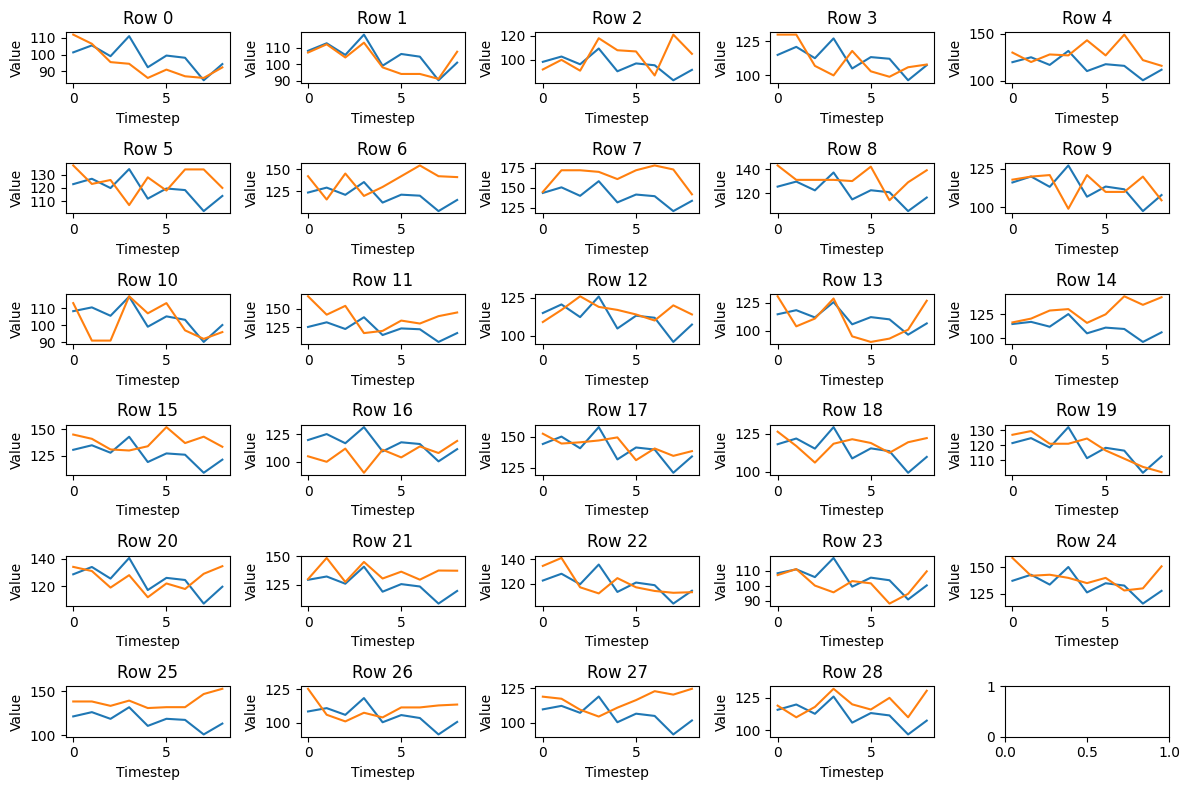

In [50]:
num_rows = 6
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten() # for easier indexing

predictions = best_model.predict(best_X_test)

# Loop through the predictions and actual values
for i in range(len(best_X_test)):
    ax = axes[i]
    ax.plot(predictions[i].tolist(), label='Predictions')

    # Plot actual values
    ax.plot(best_y_test.iloc[i,:].tolist(), label='Actual Values')

    # Customize the subplot
    ax.set_title(f'Row {best_test_index[i]}')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Value')
    # ax.legend()

# Use tight layout to ensure proper spacing
plt.tight_layout()

# Show or save the plot
plt.show()

# 計算bp>125的個數

In [58]:
def nighttime_hpt_count(y, lst):
    for i in range(len(y)):
        lst.append(sum(1 if k>125 else 0 for k in y[i]))

In [63]:
pred_count = []
true_count = []
nighttime_hpt_count(predictions, pred_count)
nighttime_hpt_count(np.array(best_y_test.values.reshape(predictions.shape[0], predictions.shape[1])), true_count)

In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
mse = mean_squared_error(pred_count, true_count)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 6.793103448275862
